In [132]:
import json
import sys
from itertools import product
from logging import Logger
from pathlib import Path
from typing import List, Literal, Optional

import Fred as fred
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import similaritymeasures
import tqdm
from IPython.display import display
from matplotlib.axes import Axes
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
import src.utils.json_util as json_util
from src.utils.iso18571 import rating_iso_18571_short

LOG: Logger = custom_log.init_logger(__name__, log_lvl=custom_log.LEVELS.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

2024-07-17 15:06:39,767 MainProcess - MainThread INFO Log start, project directory is /root/py_projects/aihiii (exist: True) || 2251031863.py


In [2]:
DATA_DIR: Path = PROJECT_DIR / "experiments" / "2024-07-17-07-18-04_baseline_channels_3D_95th"

In [29]:
RNG = np.random.default_rng(42)

In [53]:
def get_pred_data(case: Literal["train", "test"] = "train", fold: int = 1) -> np.ndarray:
    path = DATA_DIR / f"y_pred_{case}_{fold}.npy"
    LOG.info("Loading %s", path)
    db = np.load(path)[0,:,:]
    LOG.info("Loaded %s", db.shape)

    return db   


DATA_PRED = get_pred_data()

In [28]:
DATA_TRUE = np.load(PROJECT_DIR / "data"/"processed"/"doe_big_grid_20230922_154140"/"channels_3D_95th.npy")
DATA_TRUE.shape

(3125, 67, 1401)

In [20]:
RATINGS: pd.DataFrame = pd.DataFrame(json_util.load(DATA_DIR / "results.json")["summary"])
RATINGS

,03CHST0000OCCUACRD,03CHST0000OCCUACXD,03CHST0000OCCUACYD,03CHST0000OCCUACZD,03CHST0000OCCUDSXD,03CHSTLOLEOCCUFORD,03CHSTLOLEOCCUFOXD,03CHSTLOLEOCCUFOYD,03CHSTLOLEOCCUFOZD,03CHSTLORIOCCUFORD,...,03SHLDLORIOCCUFOYD,03SHLDLORIOCCUFOZD,03SHLDUPLEOCCUFORD,03SHLDUPLEOCCUFOXD,03SHLDUPLEOCCUFOYD,03SHLDUPLEOCCUFOZD,03SHLDUPRIOCCUFORD,03SHLDUPRIOCCUFOXD,03SHLDUPRIOCCUFOYD,03SHLDUPRIOCCUFOZD
Train Median,0.814839,0.808074,0.451801,0.713424,0.819683,0.807890,0.829997,0.646669,0.763013,0.659951,...,0.654179,0.72229,0.656737,0.618697,0.627492,0.561287,0.772310,0.777787,0.709525,0.755114
Test Median,0.818096,0.809157,0.451416,0.706452,0.826053,0.802448,0.832310,0.647167,0.768204,0.656141,...,0.644062,0.71634,0.660590,0.606475,0.620133,0.563267,0.766581,0.777721,0.707977,0.751829


/tmp/ipykernel_58114/3722344704.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

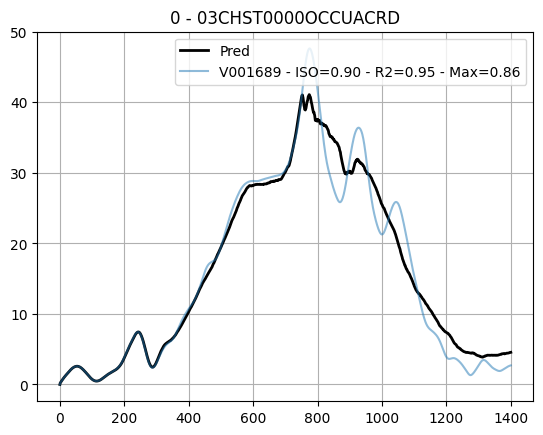

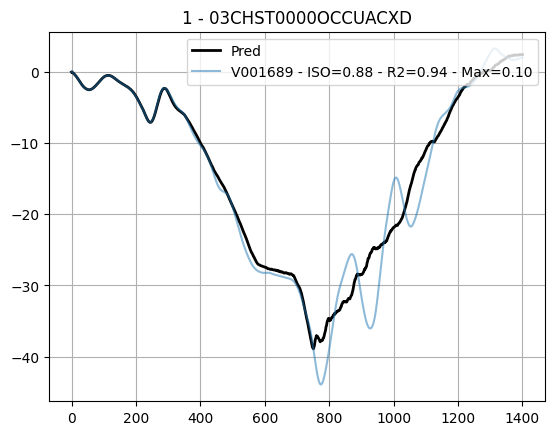

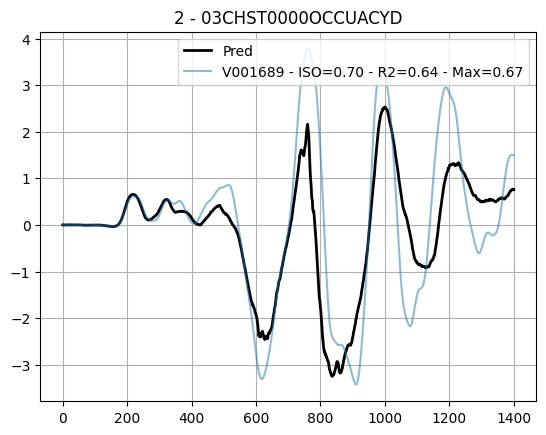

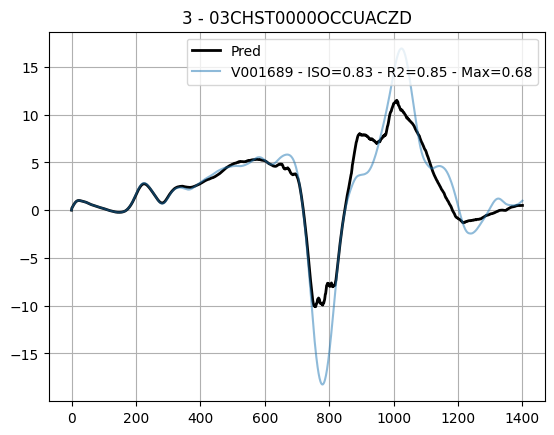

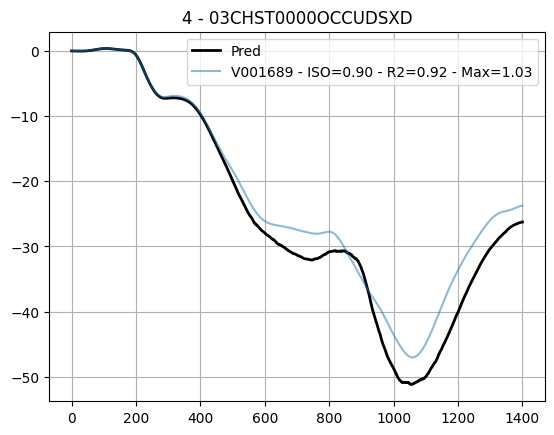

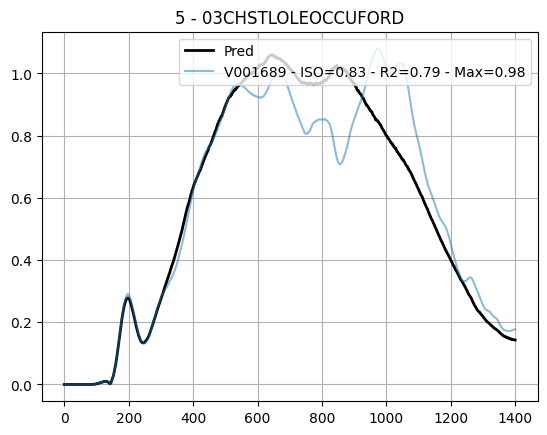

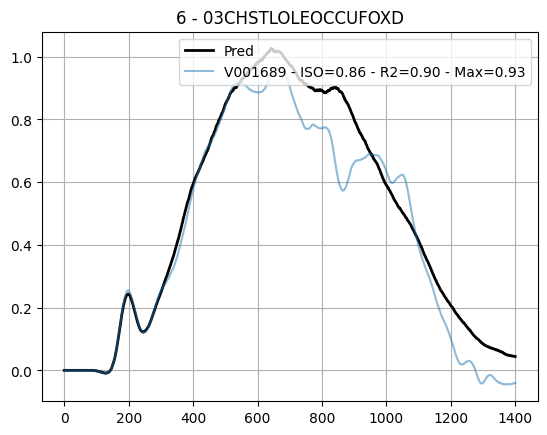

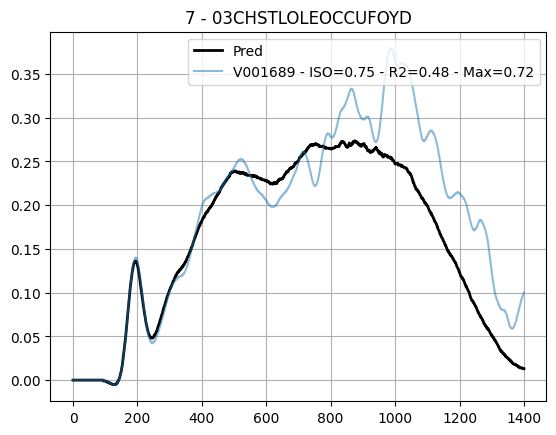

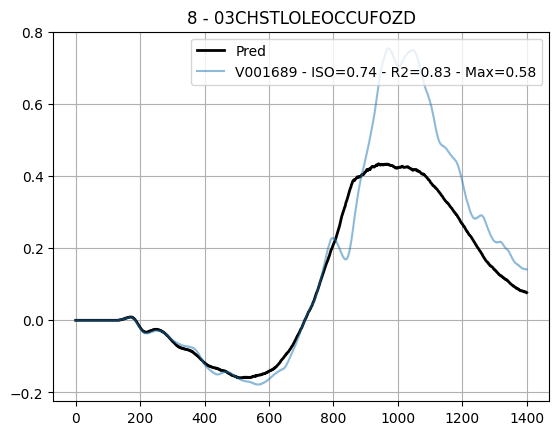

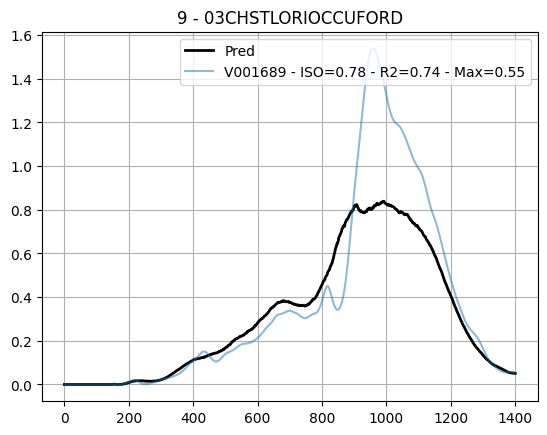

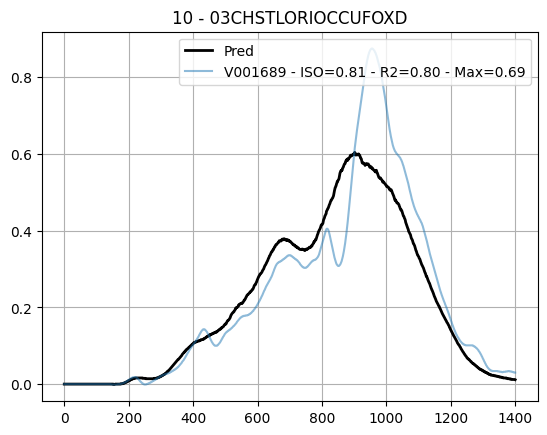

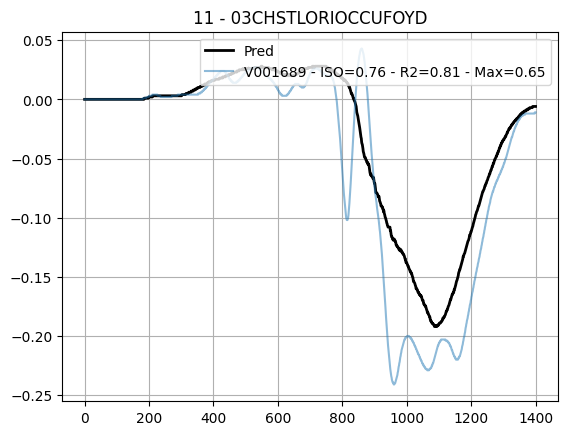

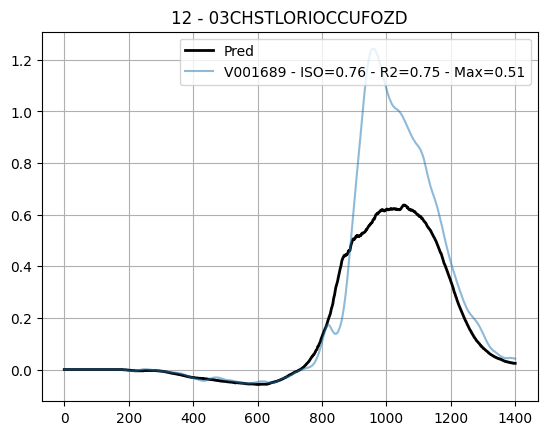

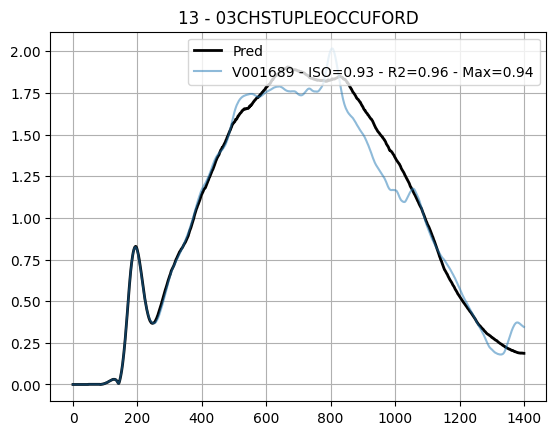

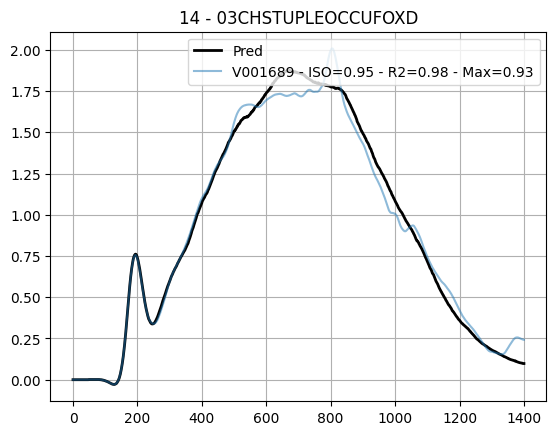

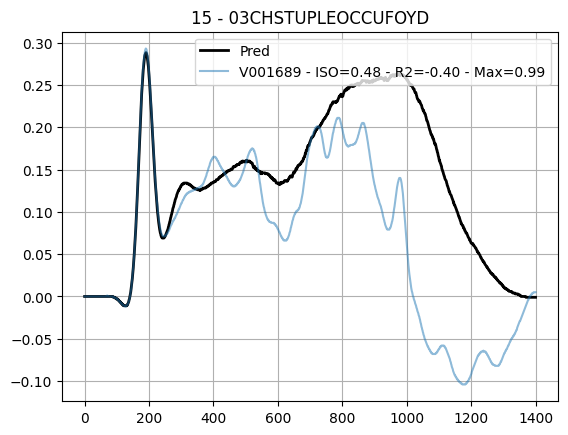

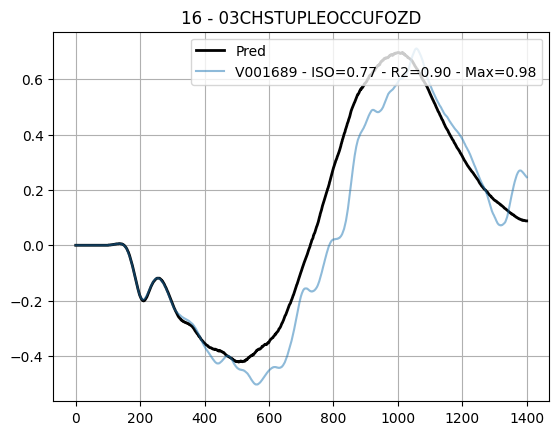

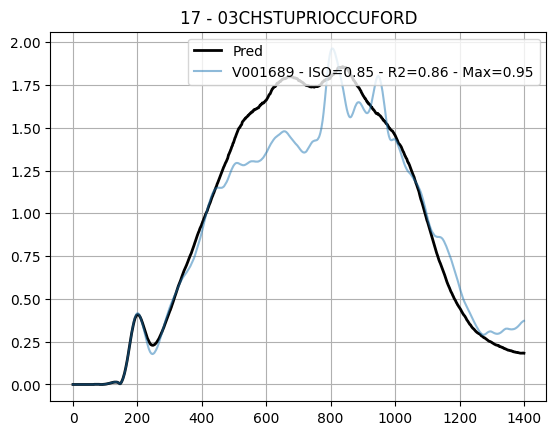

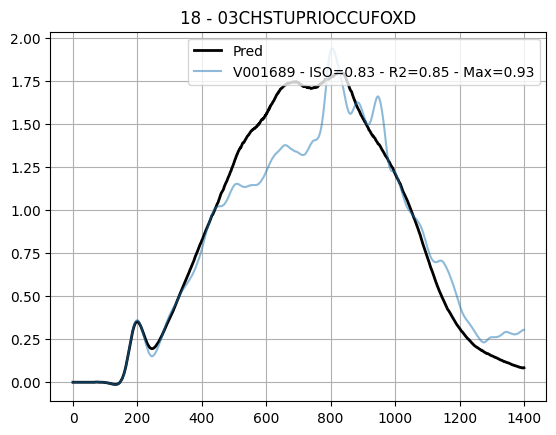

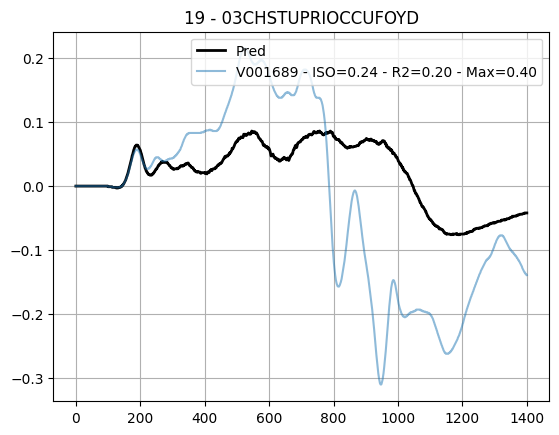

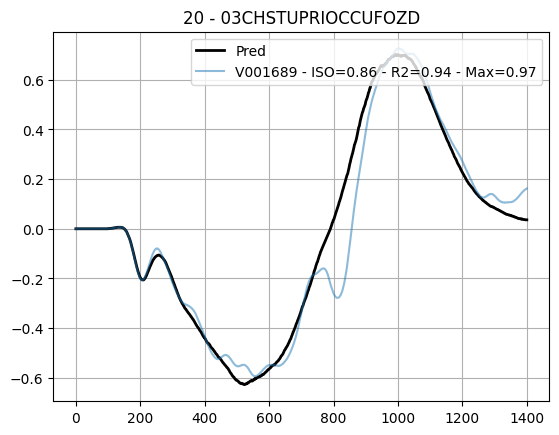

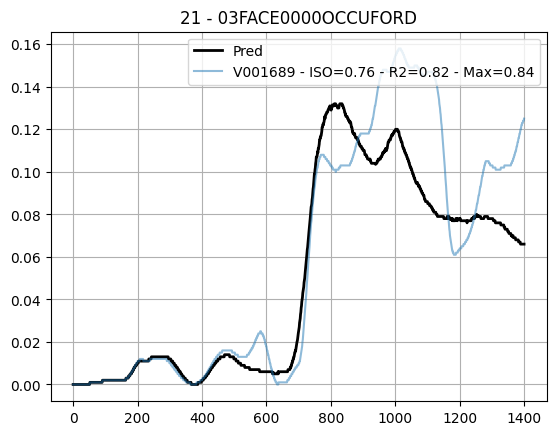

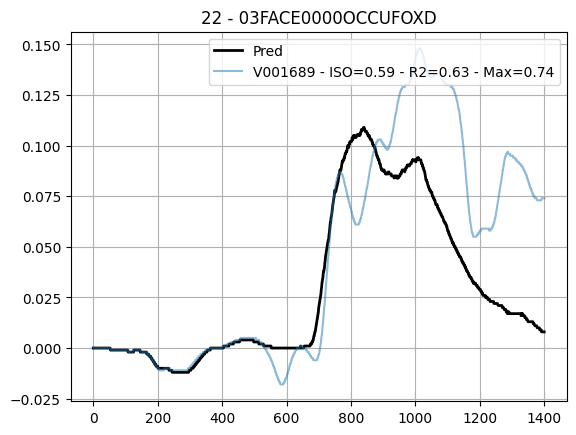

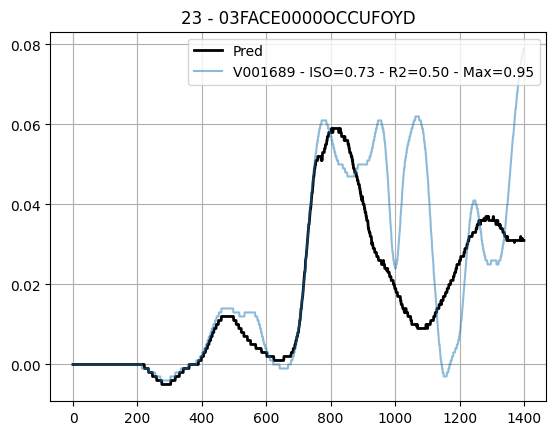

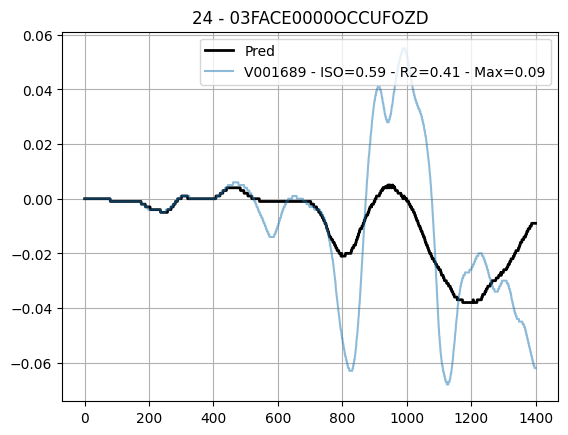

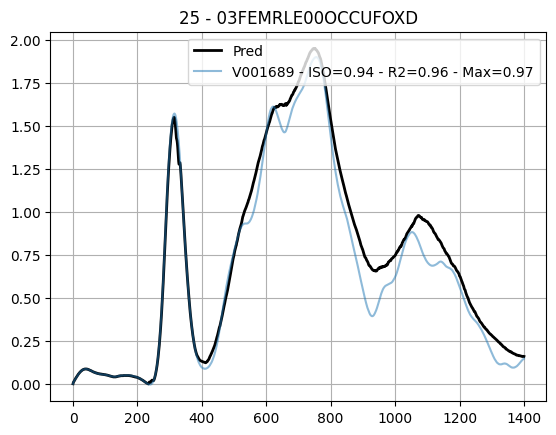

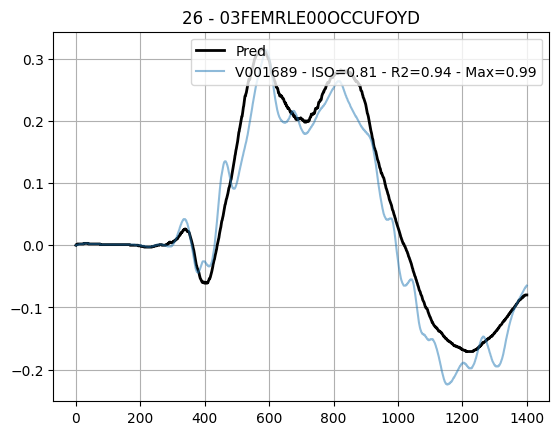

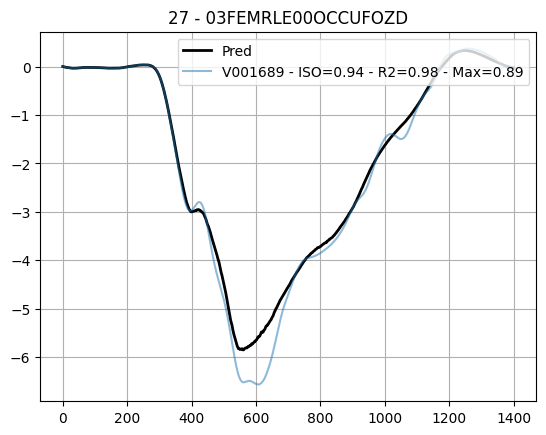

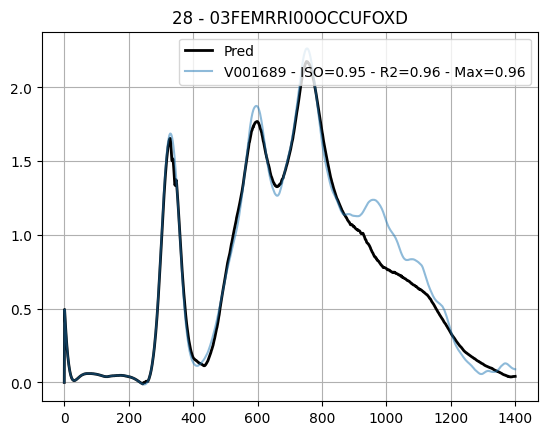

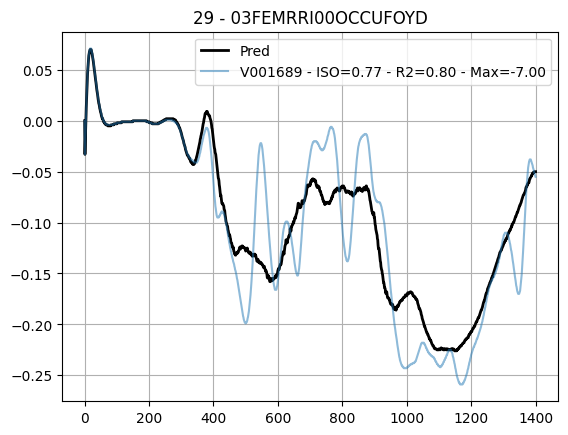

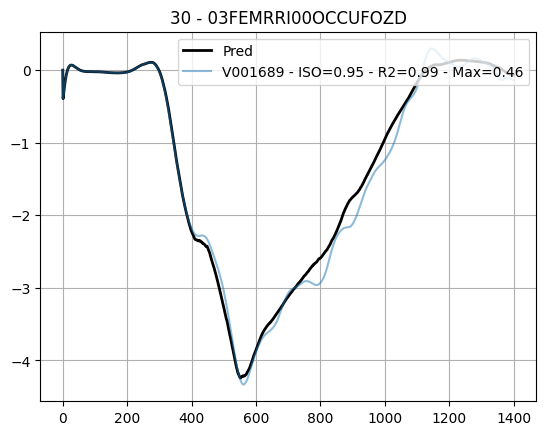

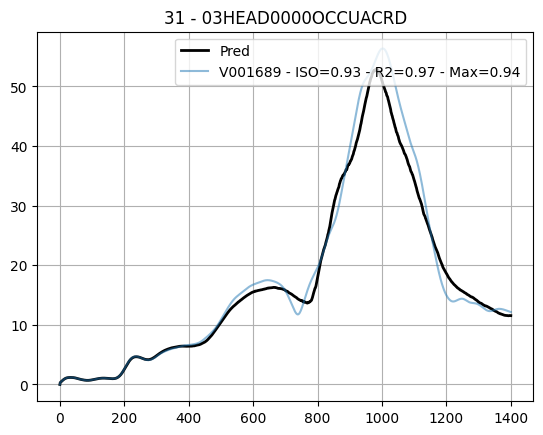

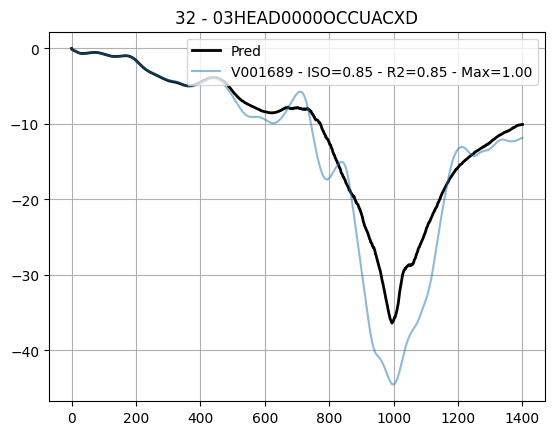

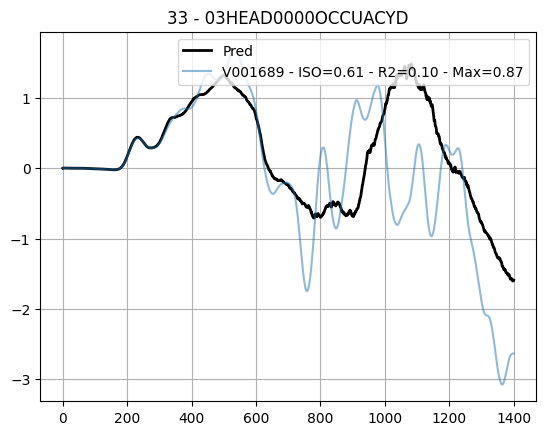

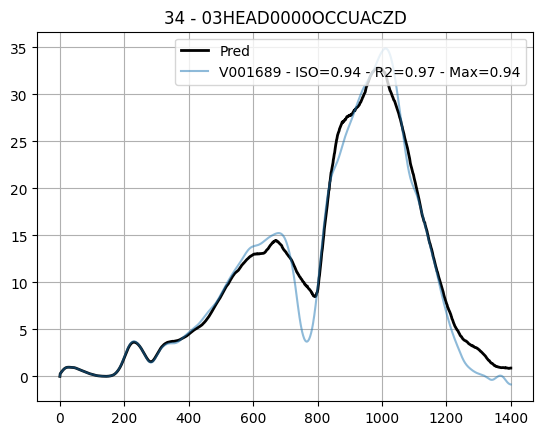

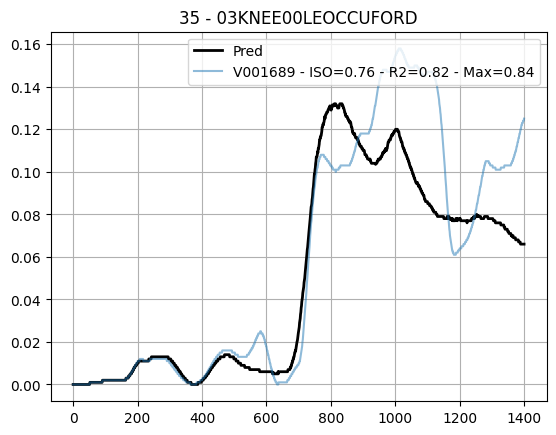

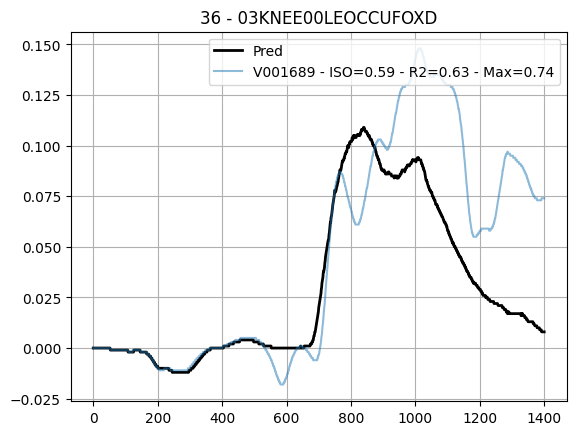

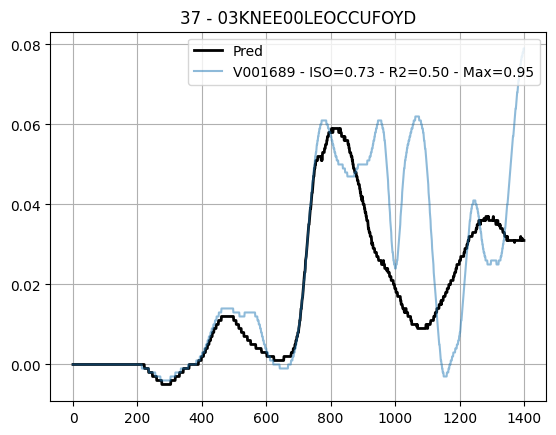

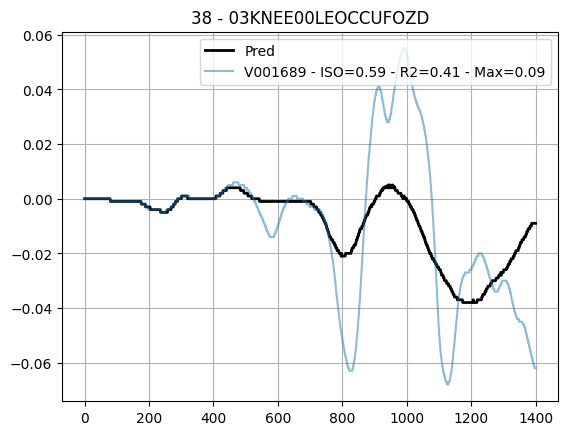

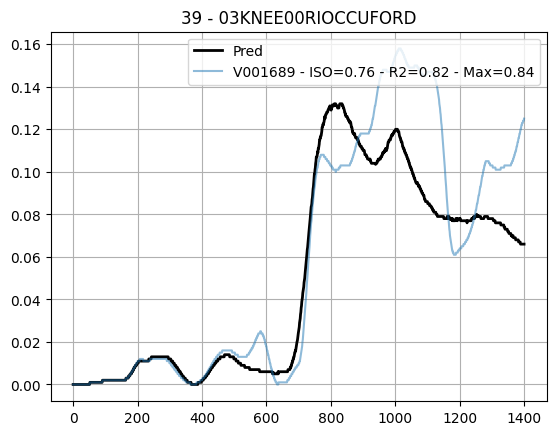

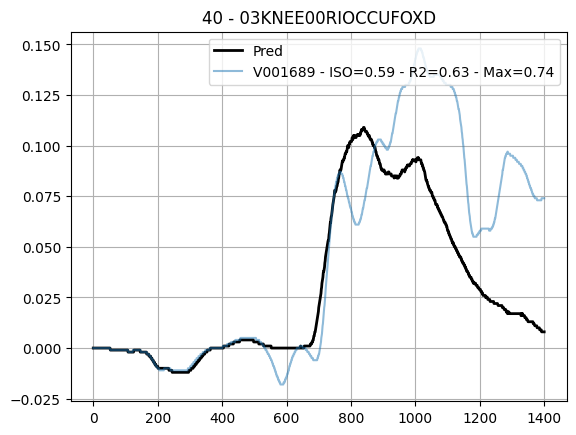

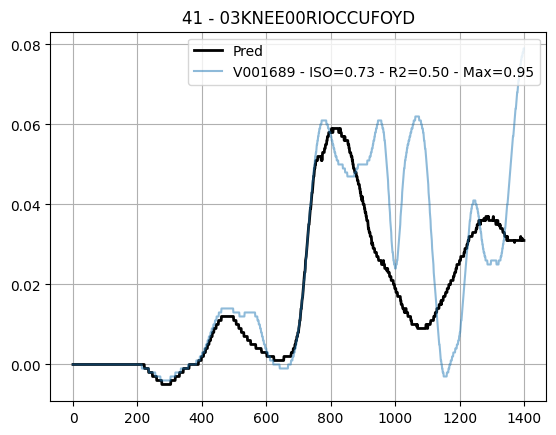

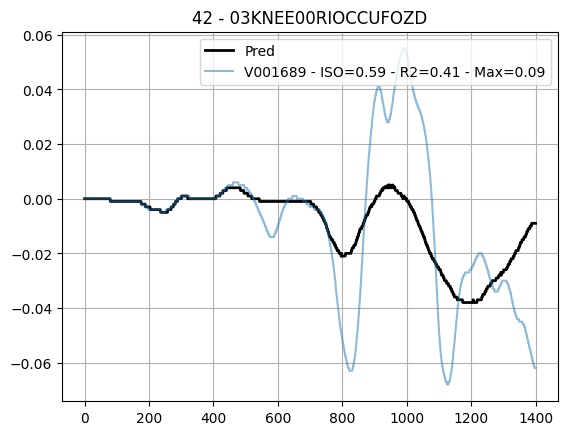

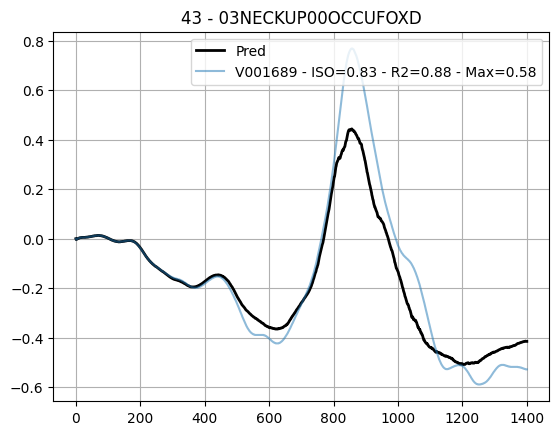

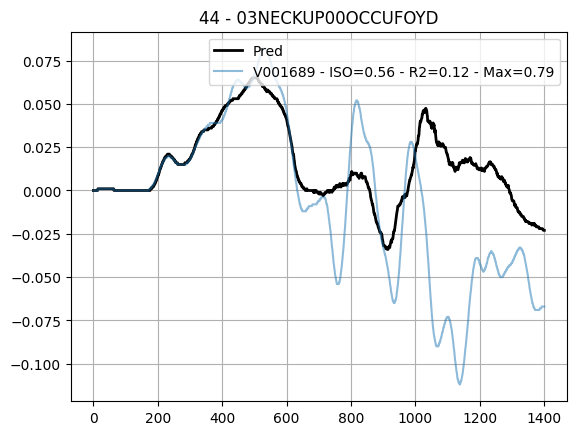

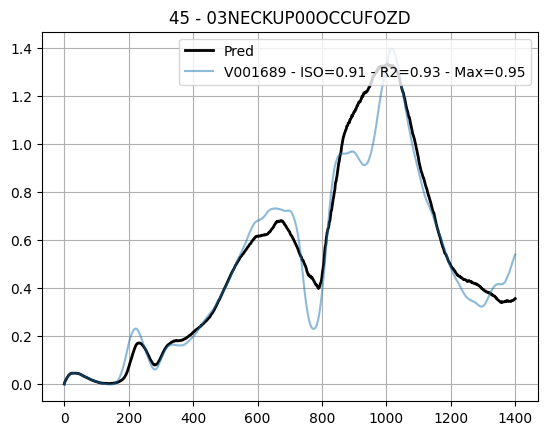

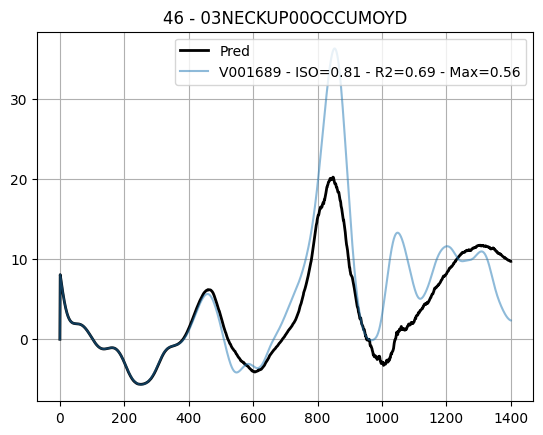

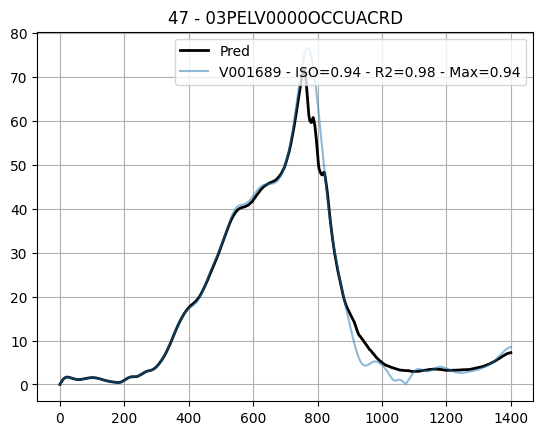

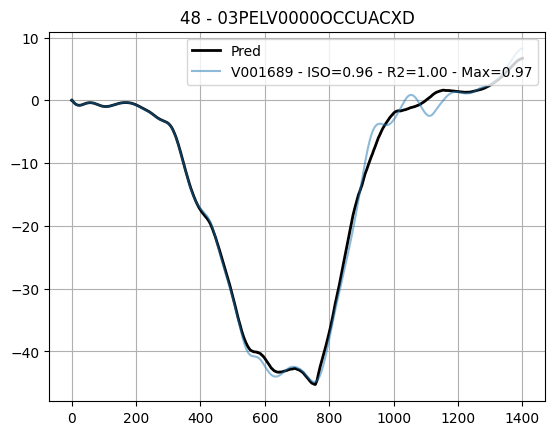

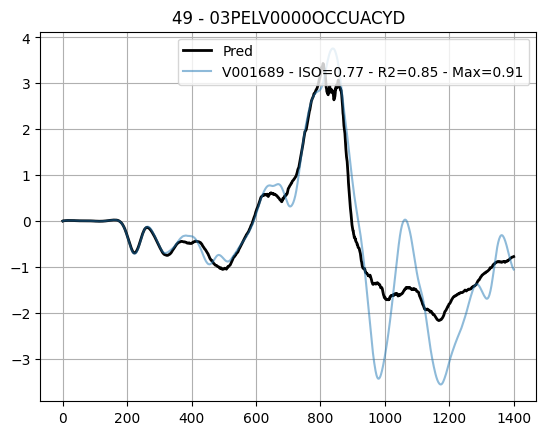

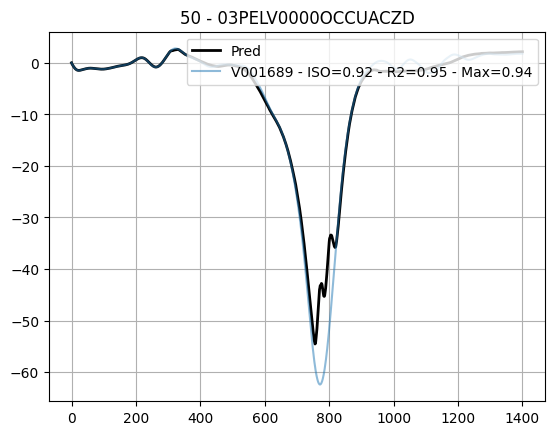

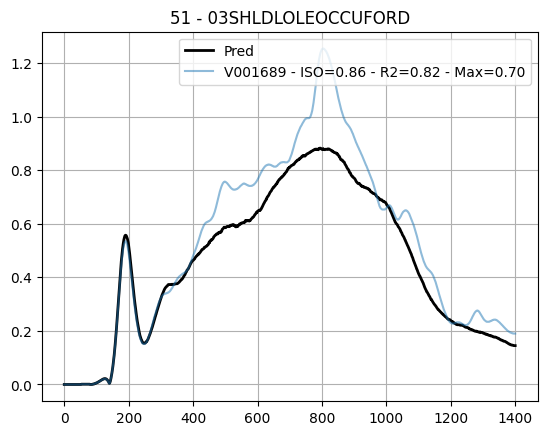

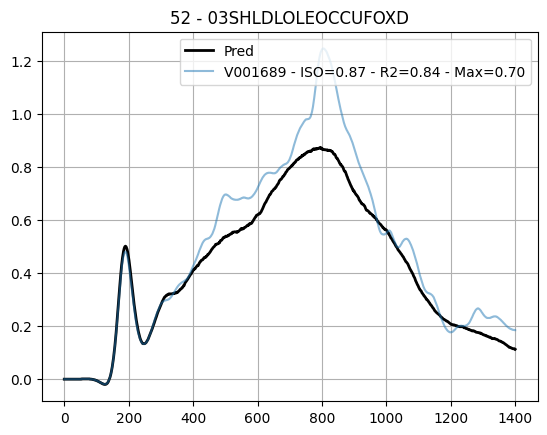

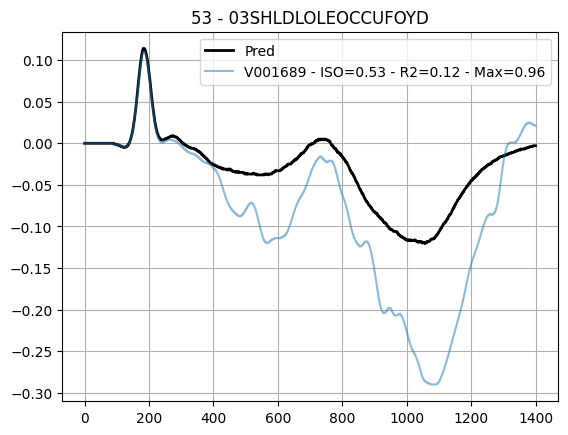

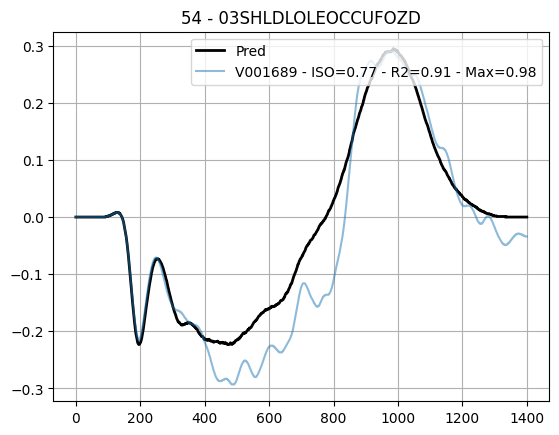

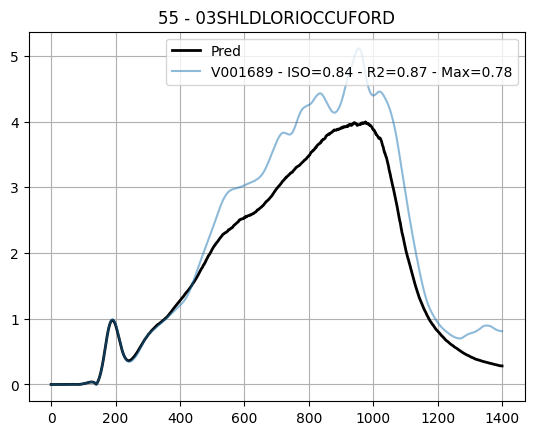

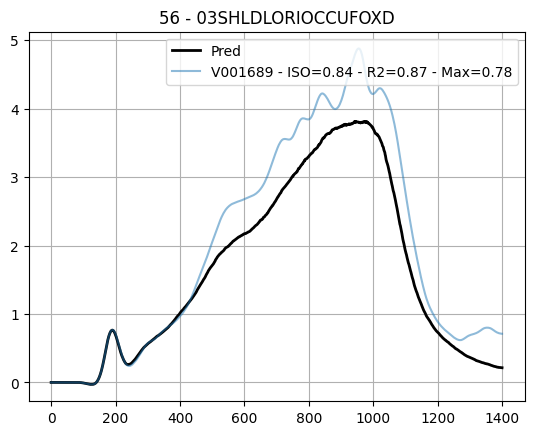

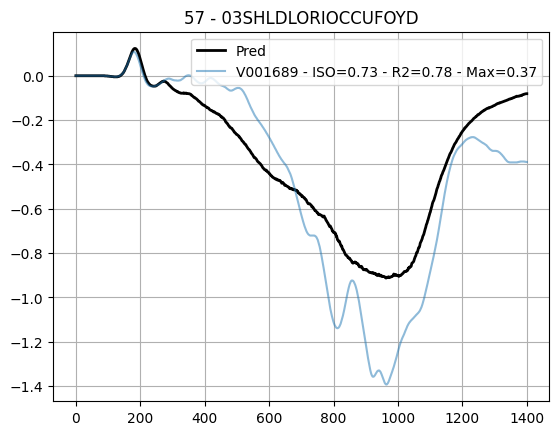

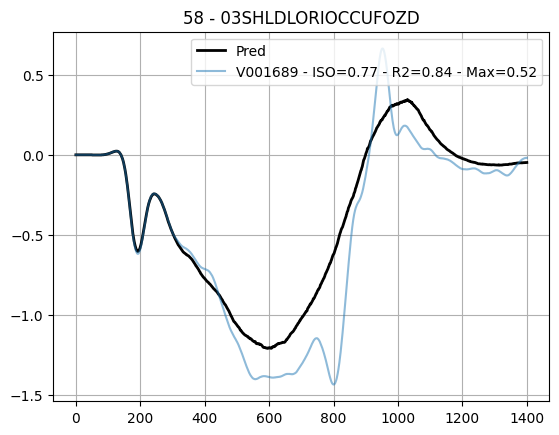

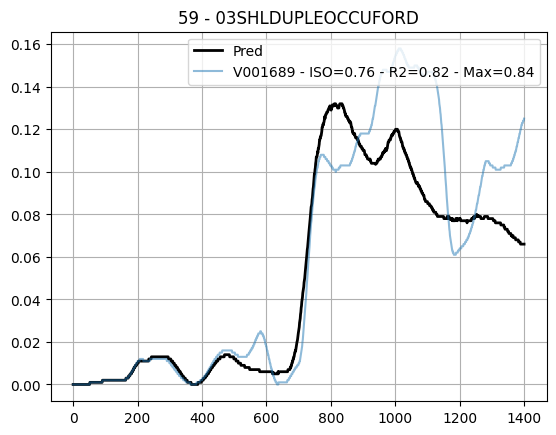

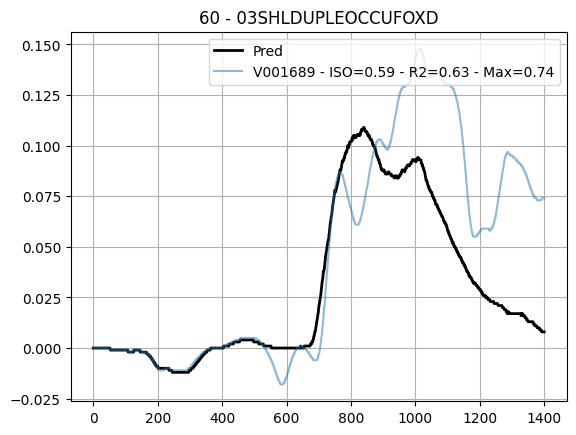

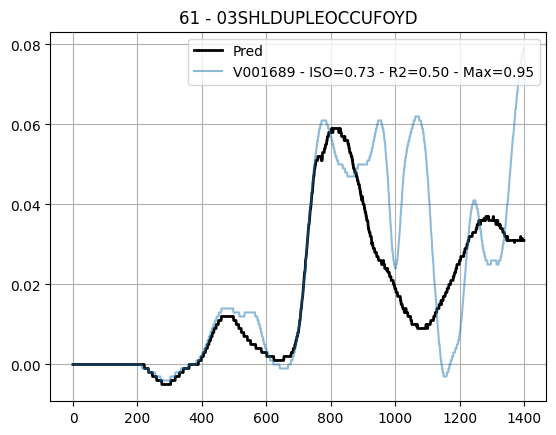

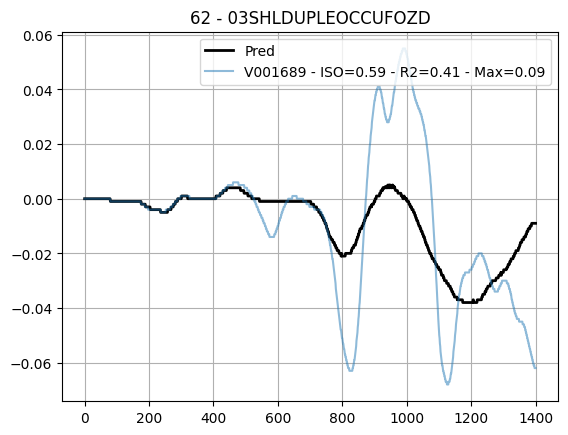

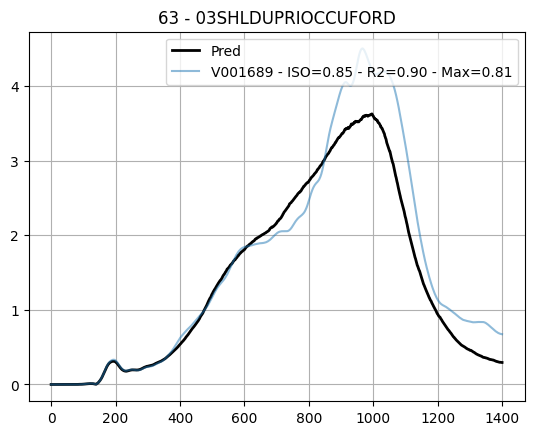

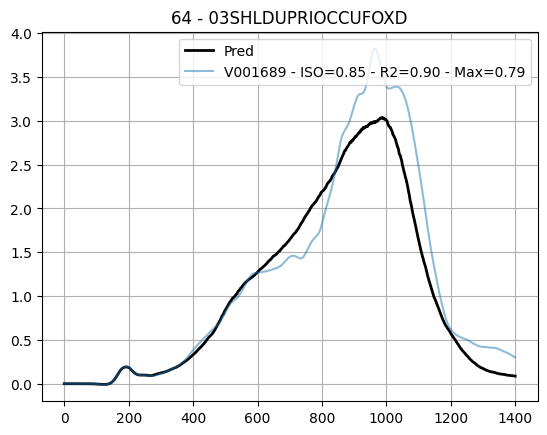

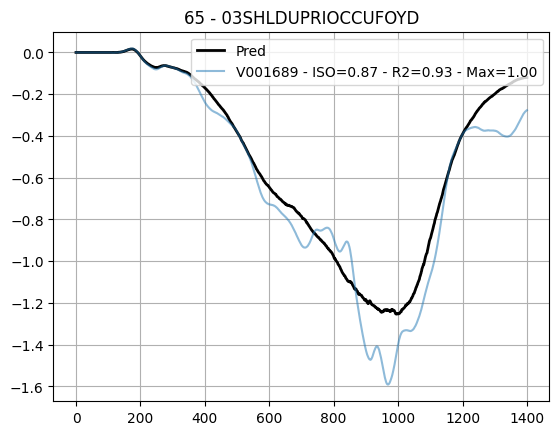

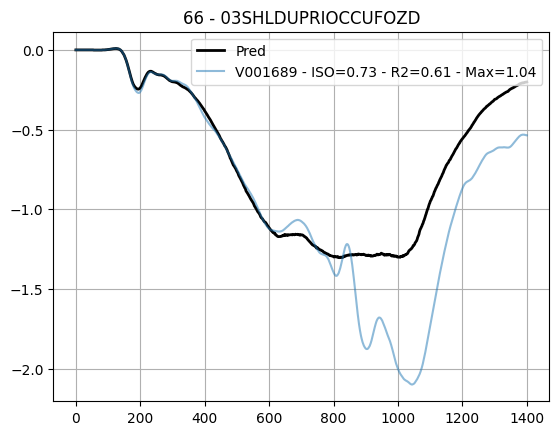

In [75]:
def plot(ch_idx: int, idx=None):
    fig, ax = plt.subplots()
    ax.set_title(f"{ch_idx} - {RATINGS.columns[ch_idx]}")

    ax.plot(DATA_PRED[ch_idx, :], label="Pred", c="black", lw=2)

    idxs = RNG.integers(0, DATA_TRUE.shape[0], 5, endpoint=True) if idx is None else [idx]
    for i in idxs:
        iso = rating_iso_18571_short(signal_ref=DATA_TRUE[i, ch_idx, 200:1301], signal_comp=DATA_PRED[ch_idx, 200:1301])
        r2 = r2_score(DATA_TRUE[i, ch_idx, 200:1301], DATA_PRED[ch_idx, 200:1301])
        maxi = 1 - np.abs(np.max(DATA_TRUE[i, ch_idx, 200:1301]) - np.max(DATA_PRED[ch_idx, 200:1301])) / np.max(
            DATA_TRUE[i, ch_idx, 200:1301]
        )
        ax.plot(DATA_TRUE[i, ch_idx, :], alpha=0.5, label=f"V{i:06d} - ISO={iso:.2f} - R2={r2:.2f} - Max={maxi:.2f}")
    ax.grid()
    ax.legend(loc=1)


[plot(ch_idx=i, idx=1689) for i in range(DATA_TRUE.shape[1])]

In [76]:
def some_isos(ch_idx: int):
    isos = []
    for i in range(DATA_TRUE.shape[0]):  # RNG.integers(0, DATA_TRUE.shape[0], 1000, endpoint=True):
        iso = rating_iso_18571_short(signal_ref=DATA_TRUE[i, ch_idx, 200:1301], signal_comp=DATA_PRED[ch_idx, 200:1301])
        isos.append(iso)

    return isos


ISOS = {i:some_isos(ch_idx=i) for i in (0, 9, 35, 43, 58)}

In [113]:
def some_r2s(ch_idx: int):
    isos = []
    for i in range(DATA_TRUE.shape[0]):  # RNG.integers(0, DATA_TRUE.shape[0], 1000, endpoint=True):
        iso = r2_score(y_true=DATA_TRUE[i, ch_idx, 200:1301], y_pred=DATA_PRED[ch_idx, 200:1301])
        isos.append(iso)

    return isos


R2S = {i:some_r2s(ch_idx=i) for i in (0, 9, 35, 43, 58)}

In [ ]:
def some_frechets2(ch_idx: int):
    isos = []
    for i in range(DATA_TRUE.shape[0]):
        iso = fred.discrete_frechet(fred.Curve(DATA_TRUE[i, ch_idx, 200:1301]), fred.Curve(DATA_PRED[ch_idx, 200:1301])).value
        isos.append(iso)

    return isos


FRECHETS = {i:some_frechets2(ch_idx=i) for i in (0, 9, 35, 43, 58)}

KeyboardInterrupt: 

In [ ]:
fred.discrete_frechet(fred.Curve(DATA_TRUE[0, 0, 200:1301]), fred.Curve(DATA_PRED[0, 200:1301])).value

[None, None, None, None, None]

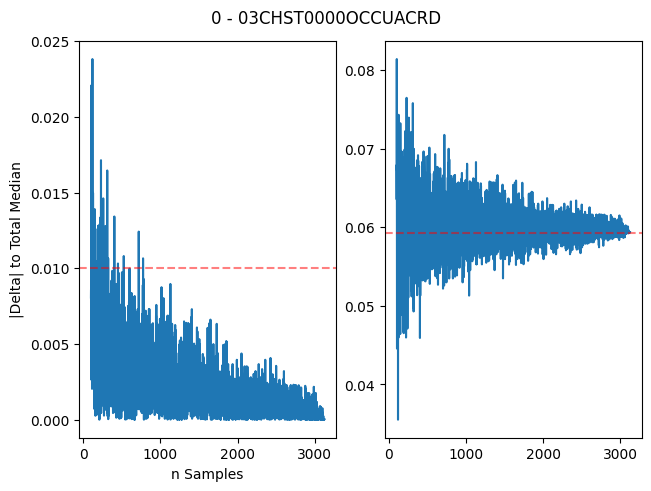

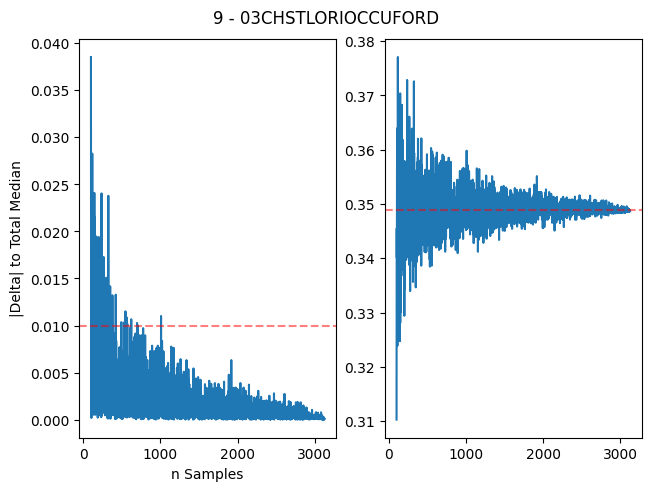

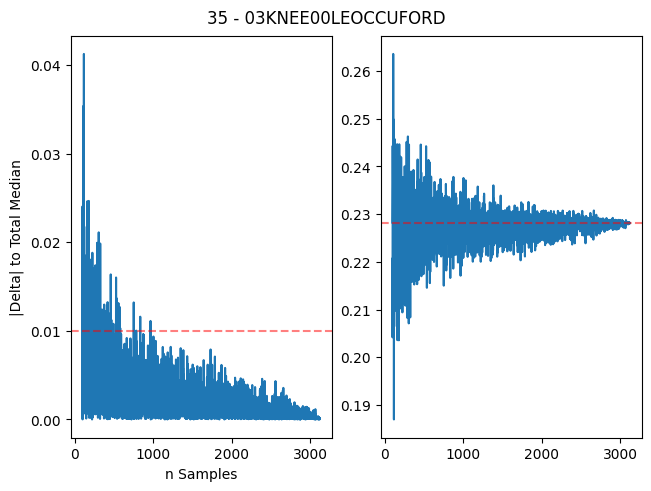

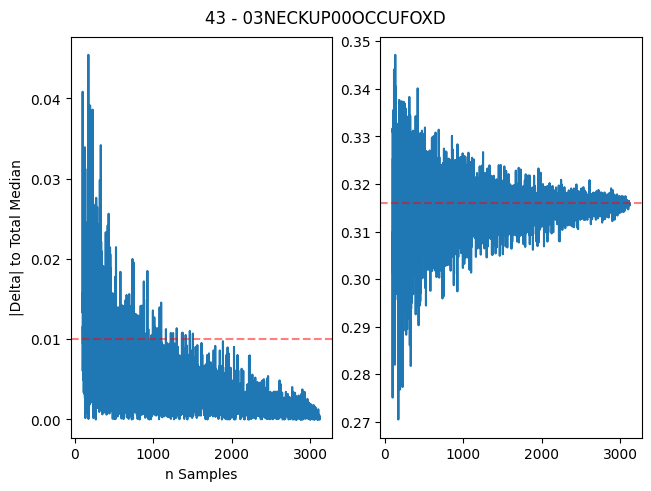

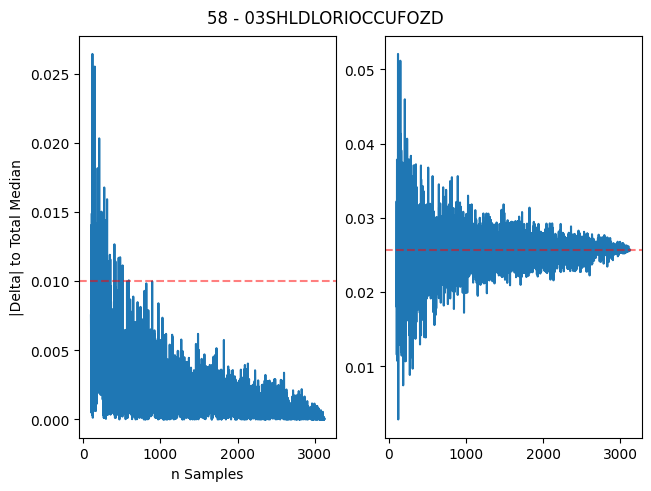

In [117]:
def sampling(ch_idx=0):
    da = np.array(
        [[sz, np.median(RNG.choice(a=ISOS[ch_idx], size=int(sz), replace=False))] for sz in range(100, len(ISOS[ch_idx]))]
    )
    fig, ax = plt.subplots(ncols=2, layout="constrained")
    fig.suptitle(f"{ch_idx} - {RATINGS.columns[ch_idx]}")
    ax[0].plot(da[:, 0], np.abs(da[:, 1] - np.median(ISOS[ch_idx])))
    ax[0].axhline(0.01, c="red", ls="--", alpha=0.5)
    ax[0].set_ylabel("|Delta| to Total Median")
    ax[0].set_xlabel("n Samples")

    ax[1].plot(da[:, 0], np.abs(da[:, 1] - np.median(R2S[ch_idx])))
    ax[1].axhline(np.abs(np.median(ISOS[ch_idx]) - np.median(R2S[ch_idx])), c="red", ls="--", alpha=0.5)


[sampling(i) for i in ISOS.keys()]

In [103]:
for i in tqdm.tqdm(list(range(2000))):
    iso = rating_iso_18571_short(signal_ref=DATA_TRUE[i, 0, 200:1301], signal_comp=DATA_PRED[0, 200:1301])

100%|██████████| 2000/2000 [01:46<00:00, 18.79it/s]


In [111]:
import time
start = start = time.time()
_ = rating_iso_18571_short(signal_ref=DATA_TRUE[0, 0, 200:1301], signal_comp=DATA_PRED[0, 200:1301])
print(time.time() - start, "s")

0.09644126892089844 s


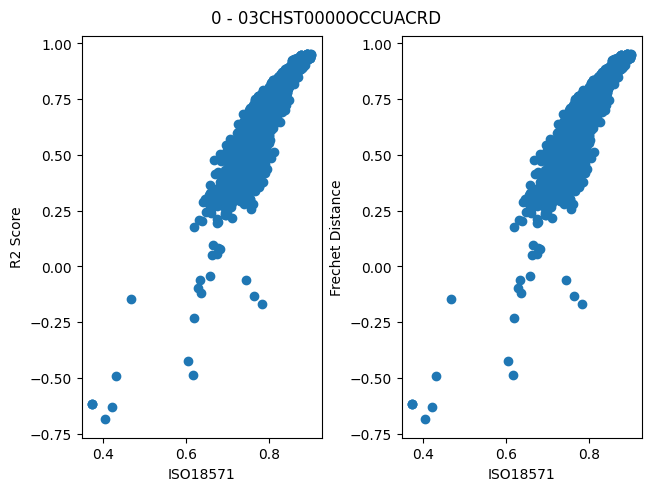

In [124]:
def correlations(ch_idx=0):
    da = np.array(
        [[sz, np.median(RNG.choice(a=ISOS[ch_idx], size=int(sz), replace=False))] for sz in range(100, len(ISOS[ch_idx]))]
    )
    fig, ax = plt.subplots(ncols=2, layout="constrained")
    fig.suptitle(f"{ch_idx} - {RATINGS.columns[ch_idx]}")
    ax[0].scatter(ISOS[ch_idx], R2S[ch_idx])
    ax[0].set_ylabel("R2 Score")
    ax[0].set_xlabel("ISO18571")

    ax[1].scatter(ISOS[ch_idx], FRECHETS[ch_idx])
    ax[1].set_ylabel("Frechet Distance")
    ax[1].set_xlabel("ISO18571")

correlations()
# [correlations(i) for i in ISOS.keys()]